In [1]:
import numpy as np
from scipy import sparse
import time

In [2]:
# Initialize mask of houses 

W = 300 

# Masks of each house
small_house = np.full((18, 18), True)
big_house = np.full((30, 78), True)
big_house[-12:, 18:] = False
rev_big_house = np.full((30, 78), True)
rev_big_house[:12, :60] = False

# Relative locations of houses in each block
block_houses = [
    ((0, 0), big_house),
    ((0, 99), small_house),
    ((69, 0), small_house),
    ((57, 39), rev_big_house),
]
block_locations = [(70, 13), (70, 166), (193, 166), (193, 13)]

HOUSES_MASK = np.full((W, W), False)
for block_x, block_y in block_locations: 
    for (x,y), mask in block_houses:
        w, h = x + block_x, y + block_y
        HOUSES_MASK[w:w + mask.shape[0], h:h+ mask.shape[1]] = mask

# True if given coordinate with given M is located on a house
def is_house(x, y, M):
    return HOUSES_MASK[round(x * M / W), round(y * M / W)]

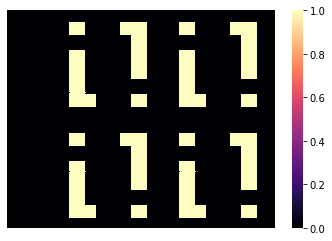

In [52]:
import seaborn as sns

def plot_heatmap(m):
    sns.heatmap(m.T[::-1], cmap="magma", xticklabels=False, yticklabels=False)

plot_heatmap(HOUSES_MASK) 

In [15]:
from numpy.linalg import norm

K = 0.5
lam1, lam2 = 1.0, 0.0
COEFS = [
    ( 1, 0, -lam1),
    (-1, 0,  lam1),
    ( 0, 1, -lam2),
    ( 0,-1,  lam2),
]

def init_trans(h, tau, M):
    f = np.zeros(M * M)
    
    A = sparse.lil_matrix((M * M, M * M))
    for i in range(M):
        A[i, i] = 1.0
    
    for x in range(1, M): 
        for y in range(M):
            i = x * M + y
            
            A[i, i] = 1 - 4 * (tau * K) / (h ** 2)
            for dn_x, dn_y, lam in COEFS:
                coef = tau * (K / (h ** 2) + lam / (2 * h))
                n_x, n_y = x + dn_x, y + dn_y
                
                if n_x <= 0:
                    f[i] = coef
                elif n_y >= M - 1 or n_x >= M - 1 or n_y <= 0 or is_house(n_x, n_y, M):
                    A[i, i] += coef
                else:
                    A[i, n_x * M + n_y] = coef
                    
    return sparse.csr_matrix(A), f

def solve(eps, M=300, n_iter=5000000):   
  h = 1 / M
  tau = h * h / (4 * K)
  A, f = init_trans(h, tau, M)
  
  U = np.zeros(M * M)
  U[:M] = 1.0
  for iter in range(n_iter):
    U_next = A.dot(U) + f
    
    if norm(U_next - U, 1) / max(1, norm(U, 1)) < eps:
        break
    else: 
        U = U_next
  return U.reshape((M, M))

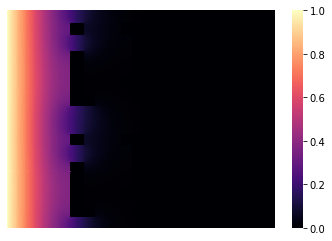

In [53]:
plot_heatmap(solve(eps=10e-5))

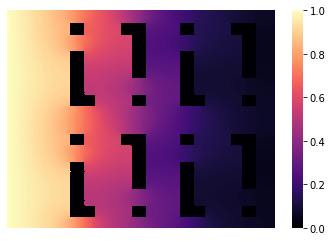

In [54]:
plot_heatmap(solve(eps=10e-6))

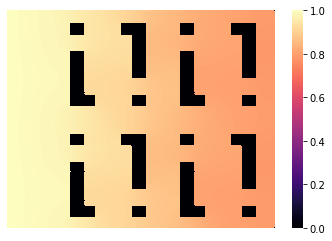

In [55]:
plot_heatmap(solve(eps=10e-7))

In [19]:
%timeit solve(eps=10e-5)

5.99 s ± 304 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit solve(eps=10e-5)

31 s ± 425 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
